Unitary iDMRG with bond dimension 2

In [2]:
import numpy as np
import cmath
import math
from scipy.stats import unitary_group
import scipy.linalg
from scipy import integrate
from ncon import ncon 
from matplotlib import pyplot as plt
import pickle 

def hc(mat):
    '''returns Hermitian conjugate'''
    return np.conj(mat).T

def polar(mat):
    '''computes polar decomposition'''
    xl, _, xr = np.linalg.svd(mat)
    return ncon([xl, xr], [[-1, 1], [1, -2]])

def get_s(d):
    '''returns a spin-up vector'''
    s = np.zeros(d)
    s[0] = 1
    return s

def heisenberg(J, B):
    '''
    returns the 2-site heisenberg hamiltonian
    input: list of spin coupling J for [x, y, z] pauli matrices'''
    # Pauli matrices
    sigx = np.array([[0, 1], [1, 0]])
    sigy = np.array([[0, -1j], [1j, 0]])
    sigz = np.array([[1, 0], [0, -1]])
    sigma = np.array([sigx, sigy, sigz]) # vector of pauli matrices
    H = np.zeros((4,4), dtype=np.complex128)
    for i in range(len(sigma)):
        H += J[i] * np.kron(sigma[i], sigma[i])/4 + B[i]*(np.kron(sigma[i], np.eye(2)) + np.kron(np.eye(2), sigma[i]))
    return H

def xy_antiferromagnet(J):
    '''returns xy antiferromagnet'''
    # Pauli matrices
    sigplus = np.array([[0, 1], [0, 0]])
    sigminus = np.array([[0, 0], [1, 0]])
    H = np.zeros((4,4), dtype=np.complex128)
    H = J/2 * (np.kron(sigplus, sigminus) + np.kron(sigminus, sigplus))
    return H

def xy_afm_soln(J):
    '''returns energy of xy antiferromagnet'''
    return J*np.cos(k)

def init_ising_hamiltonian(J, g):
    '''returns transverse ising Hamiltonian'''
    sx = np.array([[0.,1.],[1.,0.]])
    sz = np.array([[1.,0.],[0.,-1.]])
    d = 2
    H_left = -J*np.kron(sz,sz) + g * (1.0*np.kron(sx, np.eye(d)) + 0*np.kron(np.eye(d), sx))
    H_centre = -J*np.kron(sz,sz) + g * (1.0*np.kron(sx, np.eye(d)) + 0*np.kron(np.eye(d), sx))
    H_right = -J*np.kron(sz,sz) + g * (1.0*np.kron(sx, np.eye(d)) + 0*np.kron(np.eye(d), sx))
    return H_left, H_centre, H_right

def transverse_ising_soln(J, g):
    '''returns exact ground state energy of transverse ising model'''
    # andrew's code excerpt
    f = lambda k,J,g : -2*np.sqrt(J**2 + g**2 - 2*g*J*np.cos(k))/np.pi/2.
    E0_exact = integrate.quad(f, 0, np.pi, args=(J, g))[0]
    return E0_exact
        
def plot_cost_clr(cost_centre, cost_left, cost_right, savefig=None, figname=None):
    '''plots energy/cost function at each step'''
    cost_centre = np.array(cost_centre)
    cost_left = np.array(cost_left)
    cost_right = np.array(cost_right)
    xpoints = np.arange(1, len(cost_centre)+1, 1)
    fig, ax = plt.subplots()
    ax.plot(xpoints, cost_centre.real, label ='centre')
    ax.plot(xpoints, cost_left.real, label ='left')
    ax.plot(xpoints, cost_right.real, label ='right')
    ax.set_ylabel('cost')
    ax.legend()
    ax.set_xscale('log')
    ax.set_xlabel('iterations')
    plt.text(0.7, 0.8, f'J = {J:.4f} \ng = {g:.4f}', fontsize=12, transform = ax.transAxes)
    if savefig == True:
        plt.savefig(figname)
    plt.show();
    
def plot_cost(cost, savefig=None, figname=None):
    '''plots energy/cost function at each step'''
    cost = np.array(cost)/3
    xpoints = np.arange(1, len(cost)+1, 1)
    fig, ax = plt.subplots()
    ax.plot(xpoints, cost.real)
    ax.set_ylabel('cost')
    ax.set_xlabel('iterations')
    ax.set_xscale('log')
    plt.text(0.7, 0.8, f'J = {J:.4f} \ng = {g:.4f}', fontsize=12, transform = ax.transAxes)
    if savefig == True:
        plt.savefig(figname)
    plt.show();
        
def plot_rs(rs):
    rs = np.array(rs)
    xpoints = np.arange(1, len(rs)+1, 1)
    fig, ax = plt.subplots()
    ax.plot(xpoints, rs.real)
    ax.set_ylabel('Rs differences')
    ax.set_xlabel('chain length')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.axhline(c='grey', linestyle='--')
    ax.set_xscale('log')
    plt.show();
    
def plot_en(es):
    es = np.array(es)
    xpoints = np.arange(1, len(es)+1, 1)
    fig, ax = plt.subplots()
    ax.plot(xpoints, es.real)
    ax.set_ylabel('TI energy')
    ax.set_xlabel('chain length')
    ax.set_xscale('log')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.show();
        
def savedata(filename, save=False):
    if save == True:
        with open(filename + '.pkl', 'wb') as f:
            pickle.dump(data, f) 
        data_list = ['J', 'g', 'E0_exact', 'E0', 'params']
        data_list.append([data["J"], data["g"], data["E0_exact"], data["E0"], data["params"][1]])
        with open(filename + '.txt', "w") as output:
            output.write(str(data_list))
    return

def load_data(filename):
    with open(filename, 'rb') as handle:
        return pickle.load(handle)

In [3]:
class iDMRG():
    def __init__(self, H, d, D, alpha):
        H_left, H_centre, H_right = H # Hamiltonians
        self.H_left_shifted = (H_left + alpha * np.eye(d*d)).reshape(d,d,d,d)
        self.H_centre_shifted = (H_centre + alpha * np.eye(d*d)).reshape(d,d,d,d)
        self.H_right_shifted = (H_right + alpha * np.eye(d*d)).reshape(d,d,d,d)
        
        self.H_left = H_left.reshape(d,d,d,d)
        self.H_centre = H_centre.reshape(d,d,d,d)
        self.H_right = H_right.reshape(d,d,d,d)
        self.alpha = alpha # value by which hamiltonian is shifted
        
        self.step = 0
        self.d = d # physical bond dimension
        self.D = D # auxiliary bond dimension
        self.s = get_s(d)
        self.s_virtual = get_s(D)
        self.Cs = [] # stores cost fn
        self.Rs = [] # stores mean difference between right environments at each step (see self.run_iDMRG)
        self.Rs_fin = []
        self.Es = []
        self.Cs_centre = []
        self.Cs_left = []
        self.Cs_right = []

    def overlap(self, u_n, u_nm1, R):
        '''returns overlap'''
        tensors = (self.s, self.s, self.s, self.s, u_nm1, u_n, u_n, u_nm1, R, 
                   np.conj(u_nm1), np.conj(u_n), np.conj(u_n), np.conj(u_nm1), self.s, self.s, self.s, self.s)
        indices = ([1], [5], [8], [11], [1,2,3,4], [5,6,7,2], [8,9,10,6], [11,12,13,9], [12,21],
                  [14,15,3,4], [16,17,7,15], [18,19,10,17], [20,21,13,19], [14], [16], [18], [20])
        return ncon(tensors, indices)
    
    def cost_stepzero(self, u0):
        '''
        calculates cost at step 0
        '''
        tensors = (self.s, self.s, self.s_virtual, u0, u0, self.H_centre, 
                   np.conj(u0), np.conj(u0), self.s, self.s, self.s_virtual)    
        indices = ([1], [2], [3], [2, 3, 5, 4], [1, 4, 7, 6], [7, 5, 8, 9], [10, 11, 8, 6], 
                   [12, 13, 9, 11], [10], [12], [13])  
        C = ncon(tensors, indices)
        self.Cs.append(C.real)
        self.Cs_centre.append(C.real)
        self.Cs_left.append(C.real)
        self.Cs_right.append(C.real)
        
    def cost_stepone(self, u1, u0):
        '''
        calculates cost at step 1
        '''
        tensors1 = (self.s, self.s, self.s, self.s, self.s_virtual, u0, u1, u1, u0, self.H_left, np.conj(u0), 
                   np.conj(u1), np.conj(u1), np.conj(u0), self.s, self.s, self.s, self.s, self.s_virtual)
        indices1 = ([1], [2], [3], [4], [5], [1, 9, 13, 12], [2, 8, 10, 9], [3, 6, 11, 8], [4, 5, 7, 6],
                  [13, 10, 14, 15], [16, 17, 14, 12], [18, 19, 15, 17], [20, 21, 11, 19], [22, 23, 7, 21], 
                    [16], [18], [20], [22], [23])
        
        tensors2 = (self.s, self.s, self.s, self.s, self.s_virtual, u0, u1, u1, u0, self.H_centre, np.conj(u0), 
                   np.conj(u1), np.conj(u1), np.conj(u0), self.s, self.s, self.s, self.s, self.s_virtual)
        indices2 = ([1], [2], [3], [4], [5], [1, 10, 13, 12], [2, 8, 11, 10], [3, 6, 9, 8], [4, 5, 7, 6],
                   [11, 9, 14, 15], [16, 17, 13, 12], [18, 19, 14, 17], [20, 21, 15, 19], [22, 23, 7, 21],
                   [16], [18], [20], [22], [23])
        
        tensors3 = (self.s, self.s, self.s, self.s, self.s_virtual, u0, u1, u1, u0, self.H_right, np.conj(u0), 
                   np.conj(u1), np.conj(u1), np.conj(u0), self.s, self.s, self.s, self.s, self.s_virtual)
        indices3 = ([1], [2], [3], [4], [5], [1, 10, 13, 12], [2, 8, 11, 10], [3, 6, 9, 8], [4, 5, 7, 6],
                   [9, 7, 14, 15], [16, 17, 13, 12], [18, 19, 11, 17], [20, 21, 14, 19], [22, 23, 15, 21],
                   [16], [18], [20], [22], [23])
        
        C = ncon(tensors1, indices1) + ncon(tensors2, indices2) + ncon(tensors3, indices3)
        C_centre = ncon(tensors2, indices2)
        C_left = ncon(tensors1,indices1)
        C_right = ncon(tensors3,indices3)
        self.Cs.append(C.real)
        self.Cs_centre.append(C_centre.real)
        self.Cs_left.append(C_left.real)
        self.Cs_right.append(C_right.real)

    def cost_n(self, u_n, u_nm1, r_nm1):
        '''
        calculates cost at step n
        '''
        tensors1 = (self.s, self.s, self.s, self.s, u_nm1, u_n, u_n, u_nm1, self.H_left, r_nm1, np.conj(u_nm1), 
                   np.conj(u_n), np.conj(u_n), np.conj(u_nm1), self.s, self.s, self.s, self.s)
        indices1 = ([1], [2], [3], [4], [1, 8, 11, 10], [2, 9, 12, 8], [3, 6, 13, 9], [4, 5, 7, 6],
                   [11, 12, 14, 15], [5, 23], [16, 17, 14, 10], [18, 19, 15, 17], [20, 21, 13, 19], 
                    [22, 23, 7, 21], [16], [18], [20], [22])
        
        tensors2 = (self.s, self.s, self.s, self.s, u_nm1, u_n, u_n, u_nm1, self.H_centre, r_nm1, np.conj(u_nm1), 
                   np.conj(u_n), np.conj(u_n), np.conj(u_nm1), self.s, self.s, self.s, self.s)
        indices2 = ([1], [2], [3], [4], [1, 8, 13, 12], [2, 7, 9, 8], [3, 6, 10, 7], [4, 5, 11, 6],
                   [9, 10, 14, 15], [5, 23], [16, 17, 13, 12], [18, 19, 14, 17], [20, 21, 15, 19],
                   [22, 23, 11, 21], [16], [18], [20], [22])
        
        tensors3 = (self.s, self.s, self.s, self.s, u_nm1, u_n, u_n, u_nm1, self.H_right, r_nm1, np.conj(u_nm1), 
                   np.conj(u_n), np.conj(u_n), np.conj(u_nm1), self.s, self.s, self.s, self.s)
        indices3 = ([1], [2], [3], [4], [1, 8, 13, 12], [2, 7, 9, 8], [3, 6, 10, 7], [4, 5, 11, 6],
                   [10, 11, 14, 15], [5, 23], [16, 17, 13, 12], [18, 19, 9, 17], [20, 21, 14, 19], 
                    [22, 23, 15, 21], [16], [18], [20], [22])
        
        overlap = self.overlap(u_n,u_nm1,r_nm1)
        C = ncon(tensors1, indices1) + ncon(tensors2, indices2) + ncon(tensors3, indices3)/overlap
        C_centre = ncon(tensors2, indices2)/overlap
        C_left = ncon(tensors1,indices1)/overlap
        C_right = ncon(tensors3,indices3)/overlap
        self.Cs.append(C.real)
        self.Cs_centre.append(C_centre.real)
        self.Cs_left.append(C_left.real)
        self.Cs_right.append(C_right.real)
        
    def get_r(self, u, Rprev):
        '''returns right environment'''
        r = ncon((self.s, u, Rprev, np.conj(u), self.s), ([1], [1, 2, 3, -1], [2, 5], [4, 5, 3, -2], [4]))
        return r/np.trace(r) 
        
    def update_stepone(self, u1, u0, iteration):
        tensors1 = (self.s, self.s, self.s, self.s, self.s_virtual, u0, u1, u1, u0, self.H_left_shifted, 
                   np.conj(u0), np.conj(u1), np.conj(u0), self.s, self.s, self.s, self.s, self.s_virtual)
        
        tensors2 = (self.s, self.s, self.s, self.s, self.s_virtual, u0, u1, u1, u0, self.H_centre_shifted, 
                   np.conj(u0), np.conj(u1), np.conj(u0), self.s, self.s, self.s, self.s, self.s_virtual)
        
        tensors3 = (self.s, self.s, self.s, self.s, self.s_virtual, u0, u1, u1, u0, self.H_right_shifted, 
                   np.conj(u0), np.conj(u1), np.conj(u0), self.s, self.s, self.s, self.s, self.s_virtual)
        
        if iteration%2 == 0: # chop left u1dag
            indices1 = ([1], [2], [3], [4], [5], [1, 10, 13, 12], [2, 8, 11, 10], [3, 6, 9, 8], [4, 5, 7, 6],
                       [13, 11, 14, -3], [15, -4, 14, 12], [16, 17, 9, -2], [18, 19, 7, 17], 
                        [15], [-1], [16], [18], [19])

            indices2 = ([1], [2], [3], [4], [5], [1, 10, 13, 12], [2, 8, 11, 10], [3, 6, 9, 8], [4, 5, 7, 6],
                       [11, 9, -3, 14], [15, -4, 13, 12], [16, 17, 14, -2], [18, 19, 7, 17],
                       [15], [-1], [16], [18], [19])

            indices3 = ([1], [2], [3], [4], [5], [1, 9, 12, 11], [2, 8, -3, 9], [3, 6, 10, 8], [4, 5, 7, 6],
                       [10, 7, 14, 15], [13, -4, 12, 11], [16, 17, 14, -2], [18, 19, 15, 17],
                       [13], [-1], [16], [18], [19])
            
        else: # chop right u1dag
            indices1 = ([1], [2], [3], [4], [5], [1, 9, 11, 12], [2, 8, 10, 9], [3, 6, -3, 8], [4, 5, 7, 6],
                       [11, 10, 13, 14], [15, 16, 13, 12], [17, -4, 14, 16], [18, 19, 7, -2],
                       [15], [17], [-1], [18], [19])

            indices2 = ([1], [2], [3], [4], [5], [4, 5, 7, 6], [3, 6, 11, 8], [2, 8, 10, 9], [1, 9, 13, 12],
                       [10, 11, 16, -3], [14, 15, 13, 12], [17, -4, 16, 15], [18, 19, 7, -2], 
                       [14], [17], [-1], [18], [19])

            indices3 = ([1], [2], [3], [4], [5], [1, 10, 13, 12], [2, 8, 11, 10], [3, 6, 9, 8], [4, 5, 7, 6],
                       [9, 7, -3, 14], [16, 15, 13, 12], [17, -4, 11, 15], [18, 19, 14, -2], 
                        [16], [17], [-1], [18], [19])
            
        M = ncon(tensors1, indices1) + ncon(tensors2, indices2) + ncon(tensors3, indices3)
        M = M.reshape(self.d * self.D, self.d * self.D)
        u1 = polar(M)
        u1 = u1.reshape(self.d, self.D, self.d, self.D)
        return u1

    def update_n(self, u_n, u_nm1, r_nm1, iteration):
        '''updates by alternating the derivative that is taken'''
        tensors1 = (self.s, self.s, self.s, self.s, u_nm1, u_n, u_n, u_nm1, self.H_left_shifted, r_nm1, 
                   np.conj(u_nm1), np.conj(u_n), np.conj(u_nm1), self.s, self.s, self.s, self.s)
        
        tensors2 = (self.s, self.s, self.s, self.s, u_nm1, u_n, u_n, u_nm1, self.H_centre_shifted, r_nm1, 
                   np.conj(u_nm1), np.conj(u_n), np.conj(u_nm1), self.s, self.s, self.s, self.s)
        
        tensors3 = (self.s, self.s, self.s, self.s, u_nm1, u_n, u_n, u_nm1, self.H_right_shifted, r_nm1, 
                   np.conj(u_nm1), np.conj(u_n), np.conj(u_nm1), self.s, self.s, self.s, self.s)

        if iteration%2 == 0: # chop left u_n
            indices1 = ([1], [2], [3], [4], [1, 10, 13, 12], [2, 8, 11, 10], [3, 6, 9, 8], [4, 5, 7, 6],
                       [13, 11, 14, -3], [5, 19], [15, -4, 14, 12], [16, 17, 9, -2], [18, 19, 7, 17], 
                        [15], [-1], [16], [18])

            indices2 = ([1], [2], [3], [4], [1,10,13,12], [2,8,11,10], [3,6,9,8], [4,5,7,6], [11,9,-3,14], 
                        [5,19], [15,-4,13,12], [16,17,14,-2], [18,19,7,17], [15], [-1], [16], [18])

            indices3 = ([1], [2], [3], [4], [1, 9, 12, 11], [2, 8, -3, 9], [3, 6, 10, 8], [4, 5, 7, 6],
                       [10, 7, 14, 15], [5, 19], [13, -4, 12, 11], [16, 17, 14, -2], [18, 19, 15, 17],
                       [13], [-1], [16], [18])
            
        else: # chop right u_n
            indices1 = ([1], [2], [3], [4], [1, 9, 11, 12], [2, 8, 10, 9], [3, 6, -3, 8], [4, 5, 7, 6],
                       [11, 10, 13, 14], [5, 19], [15, 16, 13, 12], [17, -4, 14, 16], [18, 19, 7, -2],
                       [15], [17], [-1], [18])

            indices2 = ([1], [2], [3], [4], [4, 5, 7, 6], [3, 6, 11, 8], [2, 8, 10, 9], [1, 9, 13, 12],
                       [10, 11, 16, -3], [5, 19], [14, 15, 13, 12], [17, -4, 16, 15], [18, 19, 7, -2], 
                       [14], [17], [-1], [18])

            indices3 = ([1], [2], [3], [4], [1, 10, 13, 12], [2, 8, 11, 10], [3, 6, 9, 8], [4, 5, 7, 6],
                       [9, 7, -3, 14], [5, 19], [16, 15, 13, 12], [17, -4, 11, 15], [18, 19, 14, -2], 
                        [16], [17], [-1], [18])
        
        overlap = self.overlap(u_n, u_nm1, r_nm1)
        M = ncon(tensors1, indices1) + ncon(tensors2, indices2) + ncon(tensors3, indices3)/overlap
        M = M.reshape(self.d*self.D, self.d*self.D)
        u_n = polar(M)
        u_n = u_n.reshape(self.d, self.D, self.d, self.D)
        return u_n

        
    def optimise_stepzero(self):
        '''returns optimised u0'''
        u0 = unitary_group.rvs(self.d * self.D) # random unitary
        u0 = u0.reshape(self.d, self.D, self.d, self.D)
        self.cost_stepzero(u0) # calculate cost
        self.Es.append(self.final_energy(u0))
        # optimising
        for it in range(10):
            if it%2 == 0:
                tensors1 = (self.s, self.s, self.s_virtual, u0, u0, self.H_right_shifted, np.conj(u0), self.s, self.s, self.s_virtual)
                indices1 = ([1], [2], [3], [2, 3, 5, 4], [1, 4, 6, -4], [6, 5, -3, 7],
                            [8, 9, 7, -2], [-1], [8], [9])
                tensors2 = (self.s, self.s, self.s_virtual, u0, u0, self.H_left_shifted, np.conj(u0), self.s, self.s, self.s_virtual)
                indices2 = ([1], [2], [3], [2, 3, 5, 4], [1, 4, 7, 6], [6, 7, -4, -3], 
                            [8, 9, 5, -2], [-1], [8], [9])
            else:
                tensors1 = (self.s, self.s, self.s_virtual, u0, u0, self.H_right_shifted, np.conj(u0), self.s, self.s, self.s_virtual)
                indices1 = ([1], [2], [3], [2, 3, 5, 4], [1, 4, 7, 6], [7, 5, 8, -3],
                            [9, -4, 8, 6], [9], [-1], [-2])
                tensors2 = (self.s, self.s, self.s_virtual, u0, u0, self.H_left_shifted, np.conj(u0), self.s, self.s, self.s_virtual)
                indices2 = ([1], [2], [3], [2, 3, -3, 4], [1, 4, 6, 5], [5, 6, 7, 8], 
                            [9, -4, 8, 7], [9], [-1], [-2])                
                
            M = ncon(tensors1, indices1) + ncon(tensors2, indices2)
            M = M.reshape(self.d * self.D, self.d * self.D)
            u0_opt = polar(M)
            u0_opt = u0_opt.reshape(self.d, self.D, self.d, self.D)
            self.cost_stepzero(u0_opt) # calculate new cost
        return u0_opt
    
    def optimise_stepone(self, u0_opt, maxiter, tol):
        '''returns optimised u1 and an exitcode'''
        u1 = u0_opt.copy()
        self.cost_stepone(u1, u0_opt)
        for it in range(maxiter):
            u1 = self.update_stepone(u1, u0_opt, it)
            self.cost_stepone(u1, u0_opt)
            if it>1 and abs(abs(self.Cs[-2]) - abs(self.Cs[-1])) < tol:
                return u1, 1 # exitcode 1
        return u1, 0 # exitcode 0
   
    def optimise_n(self, u_nm1, r_nm1, maxiter, tol):
        '''returns optimised u_n and an exitcode'''
        u_n = u_nm1.copy()
        self.cost_n(u_n, u_nm1, r_nm1)
        for it in range(maxiter):
            u_n = self.update_n(u_n, u_nm1, r_nm1, it)
            self.cost_n(u_n, u_nm1, r_nm1)
            if it>1 and abs(abs(self.Cs[-2]) - abs(self.Cs[-1])) < tol:
                return u_n, 1 # exitcode 1
        return u_n, 0 # exitcode 0 
    
    def check_fp(self, u_n, R_n):
        '''checks that the right environment tensors have converged to the fixed point'''
        R = ncon((self.s, u_n, R_n, np.conj(u_n), self.s), ([1], [1, 2, 3, -1], [2, 5], [4, 5, 3, -2], [4]))
        exit = np.allclose(R-R_n, np.zeros(R.shape))
        print('\nFixed point distance:\n', (R-R_n))
        return exit
    
    def check_unitary(self, u):
        assert np.allclose(np.eye(D),
                ncon((self.s, u, np.conj(u), self.s),([1],[1,-1,3,2],[4,-2,3,2],[4]))), "u not unitary"
                 
    def final_energy(self, u_n):
        self.check_unitary(u_n)
        # the free indices have this order so that the eigensolver uses the correct axes of M
        E = ncon((self.s, u_n, np.conj(u_n), self.s), ([1], [1, -2, 2, -4], [3, -3, 2, -1], [3]))
        E = ncon((E), ([-2, -3, -4, -1]))
        E = E.reshape(D*D, D*D)
        e, R = scipy.sparse.linalg.eigen.arpack.eigs(E,k=1,which='LM')
        R = R.reshape(D, D)
        R = R/np.trace(R)
        overlap = ncon((self.s, self.s, u_n, u_n, R, np.conj(u_n), np.conj(u_n), self.s, self.s),
                      ([1], [2], [1, 4, 7, 6], [2, 3, 5, 4], [3, 11], [8, 9, 7, 6], [10, 11, 5, 9], [8], [10]))
        tensors = (self.s, self.s, u_n, u_n, self.H_centre, R, np.conj(u_n), np.conj(u_n), self.s, self.s)
        indices = ([1],[2], [2, 3, 5, 4], [1, 4, 7, 6], [7, 5, 8, 9], [3, 13], 
                   [10, 11, 8, 6], [12, 13, 9, 11], [10], [12])
        return ncon(tensors, indices)/overlap
    
    ### MAIN METHOD ### 
    def __main__(self, nsteps=10, maxiter=100, tol=1e-12, savefig=None, figname=None):
        # initialising
        u0_opt = self.optimise_stepzero()
        u1_opt, _ = self.optimise_stepone(u0_opt, maxiter, tol)
        R1 = ncon((self.s, self.s_virtual, u0_opt, np.conj(u0_opt), self.s, self.s_virtual), 
                    ([1], [2], [1, 2, 3, -2], [4, 5, 3, -1], [4], [5]))# right environment
        u2_opt, _ = self.optimise_n(u1_opt, R1, maxiter, tol)
        self.Es.append(self.final_energy(u0_opt))
        self.Es.append(self.final_energy(u1_opt))
        self.Es.append(self.final_energy(u2_opt))
        
        # start iterating
        u_nm1 = u2_opt # n = 3 to begin with
        u_nm2 = u1_opt 
        Rnew = self.get_r(u2_opt, R1)
        self.Es.append(self.final_energy(u_nm1))
        self.check_fp(u_nm1,Rnew)
        for step in range(nsteps):
            self.step += 1
            Rprev = Rnew
            u_n, exitcode = self.optimise_n(u_nm1, Rprev, maxiter, tol)
            self.check_unitary(u_n)
            Rnew = self.get_r(u_nm1, Rprev)
            self.Rs.append(np.mean(Rnew - Rprev))
            self.Es.append(self.final_energy(u_n))
            u_nm1 = u_n.copy()
                
        print('Cost function converged?', bool(exitcode))
        self.check_fp(u_n, Rnew)
        plot_cost_clr(self.Cs_centre, self.Cs_left, self.Cs_right)
        plot_cost(self.Cs)
        plot_en(self.Es)
        plot_rs(self.Rs)
        E0 = self.final_energy(u_n)
        print('ENERGY:', E0)
        return E0

----------------------------------------------------------------------------------------------------
RUN 0

Fixed point distance:
 [[-0.05186017+9.50040313e-18j  0.00133109+1.17267684e-01j]
 [ 0.00133109-1.17267684e-01j  0.05186017-6.03095618e-18j]]
Cost function converged? False

Fixed point distance:
 [[ 0.00073671-1.77614438e-18j -0.00094887+2.04528356e-03j]
 [-0.00094887-2.04528356e-03j -0.00073671+2.64350612e-18j]]


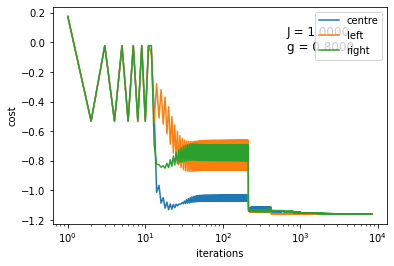

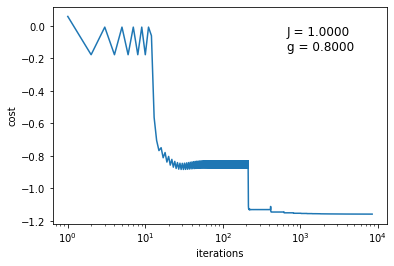

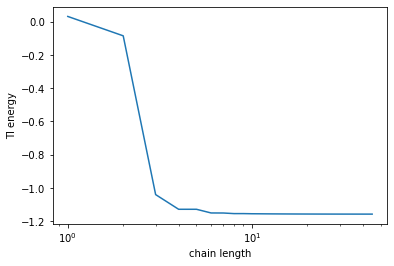

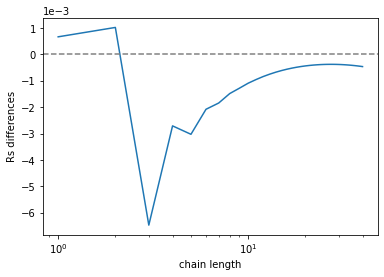

ENERGY: (-1.1580261664726084+1.8263895020592885e-17j)
EXACT GROUNDSTATE ENERGY: -1.1678095085207263


In [5]:
data = {"J":[], "g":[], "E0_exact":[], "E0":[], 
        "params": [('d', 'D', 'nsteps', 'maxiter', 'tol')]} 

d = 2
D = 2
alpha = -1
nsteps = 40
maxiter = 200
tol = 1e-12
data["params"].append((d, D, nsteps, maxiter, tol))

J = 1
gs = [0.8]
nruns = len(gs)

for run in range(nruns):
    print('-'*100)
    print('RUN', run)
    g = gs[run]
    H = init_ising_hamiltonian(J, g)
    optimiser = iDMRG(H, d, D, alpha)
    E0 = optimiser.__main__(nsteps=nsteps, maxiter=maxiter, tol=tol, savefig=False, figname=None)
    E0_exact = transverse_ising_soln(J, g)
    print('EXACT GROUNDSTATE ENERGY:', E0_exact)
    
    data["J"].append(J)
    data["g"].append(g)
    data["E0"].append(E0.real)
    data["E0_exact"].append(E0_exact)

In [6]:
np.set_printoptions(precision=12)
print(np.array(optimiser.Es[-1]).real - np.array(optimiser.Es[-2]).real)

-3.86316649447771e-06


In [6]:
optimiser.final_energy(uvumps)

(-1.2725424860564394+7.443668866014096e-17j)

In [4]:
d = 2
D = 2
alpha = -1
s = np.array([1,0])
Rvumps = np.array([[ 0.22134132+2.84155344e-16j, -0.19819993-3.30444752e-01j],
          [-0.19819993+3.30444752e-01j,  0.77865868-3.24748965e-16j]])
X = np.array([[0.,1.],[1.,0.]])
Z = np.array([[1.,0.],[0.,-1.]])
d = 2
H = -np.kron(Z,Z) + (0.5*np.kron(X, np.eye(2)) + 0.5*np.kron(np.eye(d), X))
H = H.reshape(d,d,d,d)
iters = 20
chain_length = 10
Es = optimise()

NameError: name 'optimise' is not defined